# Import packages and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [53]:
# Import training data
X_train = pd.read_csv("ais_train.csv", sep="|")
data = X_train.copy()

# Importing test data
X_test = pd.read_csv("ais_test.csv")
test = X_test.copy()

# Import ports data
ports = pd.read_csv("ports.csv", sep="|")

# Import vessels data
vessels = pd.read_csv("vessels.csv", sep="|")

#Import schedules data
schedules = pd.read_csv("schedules_to_may_2024.csv", sep="|")

# Data Inspection

## AIS training

In [3]:
data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [4]:
data.sample(5)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
306895,2024-01-27 19:36:47,157.1,0.0,0,28,0,01-25 00:15,55.62635,12.99154,61e9f465b937134a3c4c026f,61d37ffc29b60f6113c89ef0
45845,2024-01-04 22:34:38,249.3,14.3,0,244,0,01-05 12:00,50.60927,0.62810,61e9f3f3b937134a3c4bffa9,634c4de270937fc01c3a77ef
1006322,2024-03-27 03:38:22,241.2,17.0,2,242,0,03-27 22:00,25.94135,55.51915,61e9f436b937134a3c4c0139,61d37ed729b60f6113c89ced
202474,2024-01-18 23:32:58,328.1,0.0,0,167,1,01-16 22:00,45.99748,-122.85140,61e9f42db937134a3c4c00ff,61d38500b7b7526e1adf3e1f
1383613,2024-04-26 13:13:29,163.0,0.0,0,209,5,04-25 03:30,37.46165,126.60326,61e9f42fb937134a3c4c0109,61d37a571366c3998241d983


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


In [7]:
# Check for null values
data.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

In [8]:
#Counted duplicate rows
len(data)-len(data.drop_duplicates())

0

In [9]:
# Count the occurence of navstat values
data['navstat'].value_counts()

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64

<Axes: xlabel='navstat', ylabel='Count'>

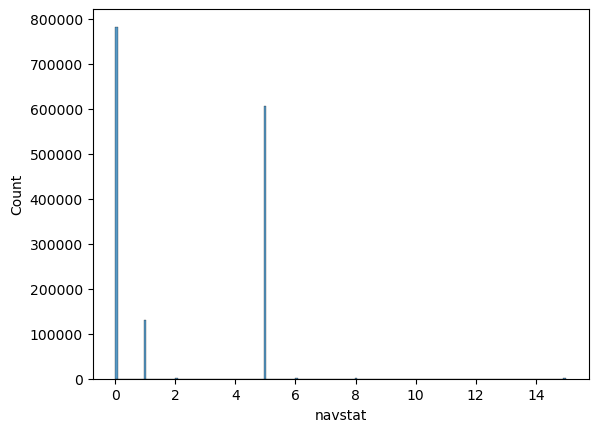

In [42]:
# Plot navstat to visualize the number of each navstat
sns.histplot(x='navstat', data = data)

<Axes: xlabel='sog'>

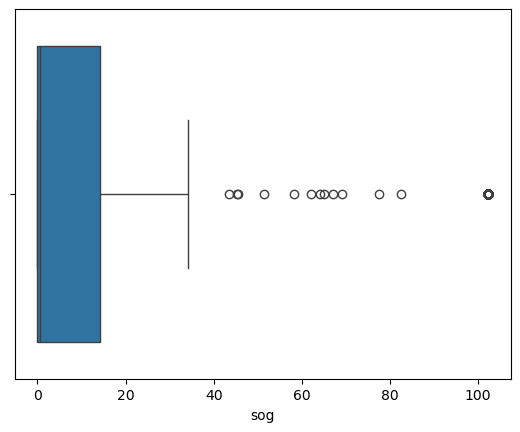

In [10]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = data)

In [11]:
# Count number of rows with sog over 40, which seems to represent the upper outliers
df_sog_greater_40 = data[data['sog'] > 40]    

unique_vessels_sog_greater_40 = df_sog_greater_40['vesselId'].unique()

#print(unique_vessels_sog_greater_40)
print('Number of unique vessels that travel over 40:', len(unique_vessels_sog_greater_40))
print('Number of entries in data with speeds over 40:', (data['sog'] > 40).sum())

Number of unique vessels that travel over 40: 33
Number of entries in data with speeds over 40: 417


<Axes: xlabel='heading'>

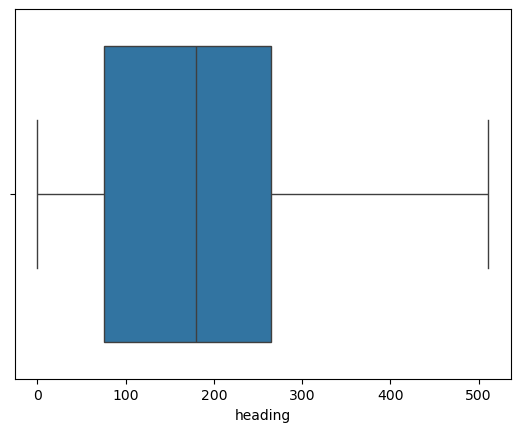

In [12]:
# Plot heading to get an idea of outliers
sns.boxplot(x = 'heading', data = data)

## Ports

In [13]:
ports.head()

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [14]:
ports.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,1329.0,20.630528,67.458101,-173.300000,-4.933,13.933,44.583000,178.426111
latitude,1329.0,35.146181,25.098764,-53.794444,25.920,39.050,53.882778,71.643056


In [15]:
ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portId        1329 non-null   object 
 1   name          1329 non-null   object 
 2   portLocation  1329 non-null   object 
 3   longitude     1329 non-null   float64
 4   latitude      1329 non-null   float64
 5   UN_LOCODE     1329 non-null   object 
 6   countryName   1329 non-null   object 
 7   ISO           1329 non-null   object 
dtypes: float64(2), object(6)
memory usage: 83.2+ KB


In [16]:
ports.isnull().sum()

portId          0
name            0
portLocation    0
longitude       0
latitude        0
UN_LOCODE       0
countryName     0
ISO             0
dtype: int64

## Vessels

In [17]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,61a8e672f9cba188601e84ab,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,61ec94f1a8cafc0e93f0e92a,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,61e213d5d612676a0f0fb755,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,61be24574ea00ae59d0fe388,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,61a8e673f9cba188601e84ae,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [18]:
vessels.describe().T

,count,mean,std,min,25%,50%,75%,max
CEU,711.0,5006.454290,2186.256335,0.00,3800.00,5400.000,6500.0000,8500.00
DWT,703.0,18556.291607,8562.952922,3222.00,14267.00,18720.000,21281.0000,108650.00
GT,711.0,51207.534459,16329.899399,8659.00,39362.00,56738.000,60619.5000,100430.00
NT,187.0,17931.326203,3838.264571,3137.00,15576.00,18474.000,19152.0000,29329.00
vesselType,699.0,72.424893,23.366361,14.00,83.00,83.000,83.0000,83.00
breadth,703.0,31.102703,3.563432,18.00,31.00,32.000,32.2600,42.00
depth,242.0,21.383140,2.658188,11.90,21.12,21.310,22.0400,32.60
draft,10.0,9.750000,3.229355,5.75,7.64,9.185,9.9325,15.40
enginePower,691.0,6789.522431,7342.526020,0.00,0.00,0.000,14121.0000,36000.00
freshWater,221.0,484.764932,136.657132,178.85,369.00,471.000,567.0000,806.58


In [19]:
vessels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shippingLineId  711 non-null    object 
 1   vesselId        711 non-null    object 
 2   CEU             711 non-null    int64  
 3   DWT             703 non-null    float64
 4   GT              711 non-null    int64  
 5   NT              187 non-null    float64
 6   vesselType      699 non-null    float64
 7   breadth         703 non-null    float64
 8   depth           242 non-null    float64
 9   draft           10 non-null     float64
 10  enginePower     691 non-null    float64
 11  freshWater      221 non-null    float64
 12  fuel            221 non-null    float64
 13  homePort        573 non-null    object 
 14  length          711 non-null    float64
 15  maxHeight       35 non-null     float64
 16  maxSpeed        213 non-null    float64
 17  maxWidth        35 non-null     flo

In [20]:
vessels.isnull().sum()

shippingLineId      0
vesselId            0
CEU                 0
DWT                 8
GT                  0
NT                524
vesselType         12
breadth             8
depth             469
draft             701
enginePower        20
freshWater        490
fuel              490
homePort          138
length              0
maxHeight         676
maxSpeed          498
maxWidth          676
rampCapacity      677
yearBuilt           0
dtype: int64

## Schedule

In [54]:
schedules.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-02 00:00:00+00:00,2023-10-03 00:00:00+00:00,Port of Brunswick,61d38499b7b7526e1adf3d54,31.140556,-81.496667
1,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,Port of Southampton,61d3832bb7b7526e1adf3b63,50.902500,-1.428889
2,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-19 00:00:00+00:00,2023-10-20 00:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
3,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-09 00:00:00+00:00,2023-10-10 00:00:00+00:00,Port of New York,61d38481b7b7526e1adf3d23,40.688333,-74.028611
4,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-09-25 00:00:00+00:00,2023-09-26 00:00:00+00:00,Manzanillo International Terminal,61d37d0199db2ccf7339eee1,9.372370,-79.879790


In [52]:
# Replace 'portId' column with integer IDs
#schedules['vesselId'] = pd.factorize(schedules['vesselId'])[0]
#schedules['shippingLineId'] = pd.factorize(schedules['shippingLineId'])[0]
#schedules['portId'] = pd.factorize(schedules['portId'])[0]
#schedules.head(10)


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,0,0,Wallenius Wilhelmsen Ocean,2023-10-02 00:00:00+00:00,2023-10-03 00:00:00+00:00,Port of Brunswick,0,31.140556,-81.496667
1,0,0,Wallenius Wilhelmsen Ocean,2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,Port of Southampton,1,50.902500,-1.428889
2,0,0,Wallenius Wilhelmsen Ocean,2023-10-19 00:00:00+00:00,2023-10-20 00:00:00+00:00,Port of Bremerhaven,2,53.563611,8.554722
3,0,0,Wallenius Wilhelmsen Ocean,2023-10-09 00:00:00+00:00,2023-10-10 00:00:00+00:00,Port of New York,3,40.688333,-74.028611
4,0,0,Wallenius Wilhelmsen Ocean,2023-09-25 00:00:00+00:00,2023-09-26 00:00:00+00:00,Manzanillo International Terminal,4,9.372370,-79.879790
5,0,0,Wallenius Wilhelmsen Ocean,2023-10-04 00:00:00+00:00,2023-10-04 00:00:00+00:00,Port of Savannah,5,32.110833,-81.125833
6,0,0,Wallenius Wilhelmsen Ocean,2023-10-06 00:00:00+00:00,2023-10-07 00:00:00+00:00,Port of Baltimore,6,39.232500,-76.558889
7,0,0,Wallenius Wilhelmsen Ocean,2023-10-22 00:00:00+00:00,2023-10-22 00:00:00+00:00,Port of Bruges-Zeebrugge,7,51.336389,3.207222
8,1,1,Hoegh Autoliners,2024-06-02 10:00:00+00:00,2024-06-04 10:00:00+00:00,Port of Durban,8,-29.881111,31.027222
9,1,1,Hoegh Autoliners,2024-05-18 22:15:00+00:00,2024-05-18 22:30:00+00:00,Port of Sohar,9,24.378333,56.740556


In [55]:
schedules.describe().T

,count,mean,std,min,25%,50%,75%,max
portLatitude,131848.0,28.021038,27.401476,-37.832778,19.208333,35.164167,50.902500,68.795000
portLongitude,131848.0,4.338822,80.059006,-149.571389,-76.558889,3.207222,39.299167,174.771111


In [56]:
schedules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136250 entries, 0 to 136249
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vesselId          131635 non-null  object 
 1   shippingLineId    136250 non-null  object 
 2   shippingLineName  136250 non-null  object 
 3   arrivalDate       130735 non-null  object 
 4   sailingDate       134369 non-null  object 
 5   portName          131848 non-null  object 
 6   portId            131848 non-null  object 
 7   portLatitude      131848 non-null  float64
 8   portLongitude     131848 non-null  float64
dtypes: float64(2), object(7)
memory usage: 9.4+ MB


In [57]:
schedules.isnull().sum()

vesselId            4615
shippingLineId         0
shippingLineName       0
arrivalDate         5515
sailingDate         1881
portName            4402
portId              4402
portLatitude        4402
portLongitude       4402
dtype: int64

In [61]:
vessel_nan = vessels[vessels['vesselId'].isnull()]
unique_vessels_data = data['vesselId'].unique()
unique_vessels_vessels = vessels['vesselId'].unique()
unique_vessels_test = test['vesselId'].unique()

# Get how many vessels that are missing in vessels are in train
vessel_nan_and_data = list(set(unique_vessels_data) & set(unique_vessels_vessels))
print(len(vessel_nan_and_data))

# Get how many vessels that are missing in vessels are in test
vessel_nan_and_test = list(set(unique_vessels_test) & set(unique_vessels_vessels))
print(len(vessel_nan_and_test))

688
215


## AIS test

In [25]:
test['vesselId'].value_counts()

vesselId
61e9f466b937134a3c4c0273    360
61e9f403b937134a3c4c0011    360
61e9f3c8b937134a3c4bfee5    360
61e9f3bcb937134a3c4bfe91    360
61e9f399b937134a3c4bfdb7    360
                           ... 
61e9f432b937134a3c4c011b    128
61e9f39fb937134a3c4bfdcd    127
6326f5a6c46d6a20d22ca31e    125
61e9f45ab937134a3c4c021b    123
61e9f41cb937134a3c4c0091    121
Name: count, Length: 215, dtype: int64

In [26]:
# Took out the rows for vessel 61e9f466b937134a3c4c0273 in train
mask = data['vesselId'].values == '61e9f466b937134a3c4c0273'

df_train_vessel_61e9f466b937134a3c4c0273 = data.loc[mask]

df_train_vessel_61e9f466b937134a3c4c0273.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1521140,2024-05-07 22:34:47,167.0,0.0,0,36,5,05-05 06:00,52.40704,4.86081,61e9f466b937134a3c4c0273,61d37be199db2ccf7339ecc0
1521346,2024-05-07 22:55:47,94.0,0.0,0,36,5,05-05 06:00,52.40704,4.86081,61e9f466b937134a3c4c0273,61d37be199db2ccf7339ecc0
1521553,2024-05-07 23:16:48,325.0,0.0,0,36,5,05-05 06:00,52.40704,4.86081,61e9f466b937134a3c4c0273,61d37be199db2ccf7339ecc0
1521786,2024-05-07 23:37:47,233.0,0.0,0,36,5,05-05 06:00,52.40704,4.86081,61e9f466b937134a3c4c0273,61d37be199db2ccf7339ecc0
1521984,2024-05-07 23:58:47,30.8,0.0,0,36,5,05-05 06:00,52.40704,4.86081,61e9f466b937134a3c4c0273,61d37be199db2ccf7339ecc0


In [27]:
# Took out the rows for vessel 61e9f466b937134a3c4c0273 in test
mask = test['vesselId'].values == '61e9f466b937134a3c4c0273'

df_test_vessel_61e9f466b937134a3c4c0273 = test.loc[mask]

df_test_vessel_61e9f466b937134a3c4c0273.head()

,ID,vesselId,time,scaling_factor
19,19,61e9f466b937134a3c4c0273,2024-05-08 00:16:47,0.3
141,141,61e9f466b937134a3c4c0273,2024-05-08 00:34:49,0.3
292,292,61e9f466b937134a3c4c0273,2024-05-08 00:52:47,0.3
458,458,61e9f466b937134a3c4c0273,2024-05-08 01:13:48,0.3
609,609,61e9f466b937134a3c4c0273,2024-05-08 01:34:47,0.3


## Comparative

In [28]:
# Get the unique vessels that are in both training and test data set into a list
unique_vessels_training = data['vesselId'].unique()
unique_vessels_test = test['vesselId'].unique()

common_vessels = list(set(unique_vessels_training) & set(unique_vessels_test))

print('Number of vessels that are in training:', len(unique_vessels_training))
print('Number of vessels that are in test:', len(unique_vessels_test))
print('Number of vessels that are the same in training and test:', len(common_vessels))

Number of vessels that are in training: 688
Number of vessels that are in test: 215
Number of vessels that are the same in training and test: 215


In [29]:
common_vessels_sog_40 = list(set(unique_vessels_sog_greater_40) & set(unique_vessels_test))

print('Number of vessels with sog over 40:', len(unique_vessels_sog_greater_40))
print('Number of unique vessels that are in test:', len(unique_vessels_test))
print('Number of vessels that have sog over 40 and are in test:', len(common_vessels_sog_40))

Number of vessels with sog over 40: 33
Number of unique vessels that are in test: 215
Number of vessels that have sog over 40 and are in test: 18


In [30]:
# Find correlation between features and longitude and latitude
data.corr(numeric_only=True).abs()[['longitude', 'latitude']]

,longitude,latitude
cog,0.011685,0.022185
sog,0.001021,0.020724
rot,0.000324,0.000746
heading,0.083895,0.063114
navstat,0.002861,0.080098
latitude,0.389560,1.000000
longitude,1.000000,0.389560


## Playground

In [31]:
data['time'] = pd.to_datetime(data['time'])

# Factorize the 'vesselID' column in X_train and get the integer IDs and the mapping
vesselID, vesselID_mapping = pd.factorize(data['vesselId'])

# Replace 'vessel_ID' column in X_train with integer IDs
data['vesselId'] = vesselID

# Create a dictionary from the mapping to apply the same to X_test
vessel_to_ID = {vessel: idx for idx, vessel in enumerate(vesselID_mapping)}

# Replace 'vesselID' in X_test using the same mapping from X_train
test['vesselId'] = test['vesselId'].map(vessel_to_ID)

sorted_data = data.sort_values(['vesselId','time'])

In [32]:
sorted_data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,61d371c43aeaecc07011a37f
2672,2024-01-01 06:09:08,92.8,14.2,0,90,0,01-09 23:00,-35.16787,-56.77210,0,61d371c43aeaecc07011a37f
2947,2024-01-01 06:38:19,90.5,14.3,0,88,0,01-09 23:00,-35.16863,-56.63185,0,61d371c43aeaecc07011a37f
3093,2024-01-01 06:58:55,88.2,14.3,0,86,0,01-09 23:00,-35.16805,-56.53190,0,61d371c43aeaecc07011a37f
3140,2024-01-01 07:15:56,88.3,12.3,0,86,0,01-09 23:00,-35.16715,-56.45306,0,61d371c43aeaecc07011a37f


In [33]:
sorted_data.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1476061,2024-05-04 04:14:57,60.7,16.0,0,54,0,05-14 15:00,37.06484,144.66435,687,61d37a061366c3998241d8f1
1476272,2024-05-04 04:35:20,58.2,15.7,0,51,0,05-14 15:00,37.11041,144.76165,687,61d37a061366c3998241d8f1
1476362,2024-05-04 04:55:03,57.7,15.4,0,50,0,05-14 15:00,37.15745,144.85164,687,61d37a061366c3998241d8f1
1476576,2024-05-04 05:16:09,58.7,15.1,0,48,0,05-14 15:00,37.20409,144.94732,687,61d37a061366c3998241d8f1
1476639,2024-05-04 05:24:33,59.8,14.9,0,48,0,05-14 15:00,37.22231,144.98452,687,61d37a061366c3998241d8f1


In [34]:
last_row_per_group = data.groupby('vesselId').tail(1)
print(last_row_per_group)

                       time    cog   sog  rot  heading  navstat       etaRaw  \
414712  2024-02-06 01:08:32  315.5   6.4    0      313       11  12-06 17:30   
507763  2024-02-14 03:52:58  119.9   0.0    2      332        5  12-25 15:00   
927386  2024-03-20 17:13:04  273.8  15.5    0      275        0  04-05 15:00   
928128  2024-03-20 18:19:26   38.8  15.6    0       42        0  03-21 20:00   
966782  2024-03-23 16:29:44  111.6   0.0  128      511        5  01-01 04:00   
...                     ...    ...   ...  ...      ...      ...          ...   
1522060 2024-05-07 23:59:07  359.1  13.4    0        1        0  05-08 05:00   
1522061 2024-05-07 23:59:08   12.3  17.1    0       13        0  05-10 03:00   
1522062 2024-05-07 23:59:08  269.8  14.9   -1      270        0  05-15 23:00   
1522063 2024-05-07 23:59:08    8.0  18.7    0        6        0  05-08 12:45   
1522064 2024-05-07 23:59:08  336.0  14.3    5      337        0  05-07 23:00   

         latitude  longitude  vesselId 

In [35]:
test.head()

,ID,vesselId,time,scaling_factor
0,0,412,2024-05-08 00:03:16,0.3
1,1,373,2024-05-08 00:06:17,0.3
2,2,181,2024-05-08 00:10:02,0.3
3,3,8,2024-05-08 00:10:34,0.3
4,4,65,2024-05-08 00:12:27,0.3


In [36]:
vessel412 = last_row_per_group[last_row_per_group['vesselId'] == 412]
print(vessel412)

                       time    cog  sog  rot  heading  navstat       etaRaw  \
1521883 2024-05-07 23:48:16  179.6  0.0    0      344        5  05-06 10:45   

         latitude  longitude  vesselId                    portId  
1521883  31.14647  -81.49789       412  61d38499b7b7526e1adf3d54  


In [37]:
vessel373 = last_row_per_group[last_row_per_group['vesselId'] == 373]
print(vessel373)

                       time   cog  sog  rot  heading  navstat       etaRaw  \
1521940 2024-05-07 23:57:16  24.7  0.0    0      214        5  05-01 23:00   

         latitude  longitude  vesselId                    portId  
1521940  14.81694  120.29625       373  61d37d5799db2ccf7339ef3b  


In [38]:
# Step 1: Get the last observed values for each 'vesselID' from training data
last_observed = data.groupby('vesselId').last().reset_index()

# Step 2: Merge the last observed values into the test data
# Left merge to keep all rows from the test data
test = pd.merge(test, last_observed, on='vesselId', how='left')

# Display the updated test DataFrame
print(test)

          ID  vesselId               time_x  scaling_factor  \
0          0       412  2024-05-08 00:03:16             0.3   
1          1       373  2024-05-08 00:06:17             0.3   
2          2       181  2024-05-08 00:10:02             0.3   
3          3         8  2024-05-08 00:10:34             0.3   
4          4        65  2024-05-08 00:12:27             0.3   
...      ...       ...                  ...             ...   
51734  51734       244  2024-05-12 23:59:58             0.1   
51735  51735         3  2024-05-12 23:59:58             0.1   
51736  51736        30  2024-05-12 23:59:58             0.1   
51737  51737        36  2024-05-12 23:59:58             0.1   
51738  51738        12  2024-05-12 23:59:58             0.1   

                   time_y    cog   sog  rot  heading  navstat       etaRaw  \
0     2024-05-07 23:48:16  179.6   0.0    0      344        5  05-06 10:45   
1     2024-05-07 23:57:16   24.7   0.0    0      214        5  05-01 23:00   
2     202

In [39]:
test.isnull().sum()

ID                0
vesselId          0
time_x            0
scaling_factor    0
time_y            0
cog               0
sog               0
rot               0
heading           0
navstat           0
etaRaw            0
latitude          0
longitude         0
portId            0
dtype: int64

In [40]:
vessel0 = test[test['vesselId'] == 412]
print(vessel0)

          ID  vesselId               time_x  scaling_factor  \
0          0       412  2024-05-08 00:03:16             0.3   
143      143       412  2024-05-08 00:36:14             0.3   
282      282       412  2024-05-08 00:51:12             0.3   
426      426       412  2024-05-08 01:12:14             0.3   
551      551       412  2024-05-08 01:30:14             0.3   
...      ...       ...                  ...             ...   
51149  51149       412  2024-05-12 22:37:31             0.1   
51272  51272       412  2024-05-12 22:58:00             0.1   
51447  51447       412  2024-05-12 23:18:20             0.1   
51587  51587       412  2024-05-12 23:39:19             0.1   
51722  51722       412  2024-05-12 23:59:55             0.1   

                   time_y    cog  sog  rot  heading  navstat       etaRaw  \
0     2024-05-07 23:48:16  179.6  0.0    0      344        5  05-06 10:45   
143   2024-05-07 23:48:16  179.6  0.0    0      344        5  05-06 10:45   
282   2024-0

In [62]:
data['latitude_lag1'] = data.groupby('vesselId')['latitude'].shift(1)    
data['longitude_lag1'] = data.groupby('vesselId')['longitude'].shift(1)
data['latitude_lag2'] = data.groupby('vesselId')['latitude'].shift(2)    
data['longitude_lag2'] = data.groupby('vesselId')['longitude'].shift(2)
data['latitude_lag3'] = data.groupby('vesselId')['latitude'].shift(3)    
data['longitude_lag3'] = data.groupby('vesselId')['longitude'].shift(3)   

In [64]:
vessel_test = data[data['vesselId'] == '61e9f3a8b937134a3c4bfdf7']
vessel_test.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_lag1,longitude_lag1,latitude_lag2,longitude_lag2,latitude_lag3,longitude_lag3
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,NaN,NaN,NaN,NaN,NaN,NaN
2672,2024-01-01 06:09:08,92.8,14.2,0,90,0,01-09 23:00,-35.16787,-56.77210,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,-34.74370,-57.85130,NaN,NaN,NaN,NaN
2947,2024-01-01 06:38:19,90.5,14.3,0,88,0,01-09 23:00,-35.16863,-56.63185,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,-35.16787,-56.77210,-34.74370,-57.85130,NaN,NaN
3093,2024-01-01 06:58:55,88.2,14.3,0,86,0,01-09 23:00,-35.16805,-56.53190,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,-35.16863,-56.63185,-35.16787,-56.77210,-34.74370,-57.8513
3140,2024-01-01 07:15:56,88.3,12.3,0,86,0,01-09 23:00,-35.16715,-56.45306,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,-35.16805,-56.53190,-35.16863,-56.63185,-35.16787,-56.7721


In [63]:
data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_lag1,longitude_lag1,latitude_lag2,longitude_lag2,latitude_lag3,longitude_lag3
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,NaN,NaN,NaN,NaN,NaN,NaN
